<a href="https://colab.research.google.com/github/ioanabirlan/wids-datathon-university-solution1/blob/main/Route2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fires and social vulnerability: territorial-level analysis in the USA

**Team Name**: Data Firefighters
**University**: _Bucharest University of Economic Studies_  
**Course**: _Machine Learning in Python  
**Term**: 1st Semester, 2025-2026

**Team Members**:  
*PIRVAN Vlad-George,
*NICOLA Eduard-George,
*LUPES Razvan-Stefan,

### 🔹 Track 2: Designing for Economic Resilience

**Core Question:**  
*How can wildfire disruption analytics inform stronger economic safety nets for affected workers, families, and small businesses?*

This route is about quantifying how wildfires affect employment, income, and tourism — and using that insight to design better protections for vulnerable communities.

## Dataset Overview

Summarize the datasets you used and how you processed them.

- `infrastructure.csv`: Metadata and coordinates of infrastructure
- `fire_perimeters.geojson`: Timestamped fire perimeter polygons
- `evacuation_zones.csv`: (Optional) evacuation declarations
- `watch_duty_change_log.csv`: Alerts and timestamps
- US census data

**Load data**

Kaggle data

Preview shows cleaned wildfire events with key metadata:
- Each row = one wildfire incident with location (lat/lng), timestamps, and extracted attributes.
- Dataset is ready for spatial or temporal merging with census and alert data.

Kaggle Json upload (Mandatory every new run)


Downloading the data (the CSV files) from the Kaggle website related to the competition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

project_path = "/content/drive/MyDrive/Proiect_ML"
os.chdir(project_path)

print("Working dir:", os.getcwd())


Mounted at /content/drive
Working dir: /content/drive/MyDrive/Proiect_ML


In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c wids-university-datathon-2025 -p data


 96% 388M/403M [00:02<00:00, 75.3MB/s]
100% 403M/403M [00:03<00:00, 141MB/s] 


In [ ]:
!unzip -o data/wids-university-datathon-2025.zip -d data


Archive:  data/wids-university-datathon-2025.zip
  inflating: data/WiDS _-_ Watch Duty_ Data Dictionary.docx  
  inflating: data/evac_zone_status_geo_event_map.csv  
  inflating: data/evac_zones_gis_evaczone.csv  
  inflating: data/evac_zones_gis_evaczonechangelog.csv  
  inflating: data/fire_perimeters_gis_fireperimeter.csv  
  inflating: data/fire_perimeters_gis_fireperimeterchangelog.csv  
  inflating: data/geo_events_externalgeoevent.csv  
  inflating: data/geo_events_externalgeoeventchangelog.csv  
  inflating: data/geo_events_geoevent.csv  
  inflating: data/geo_events_geoeventchangelog.csv  


STEP I: DATA PROCESSING AND CLEANING

Loading the CSV files downloaded from Kaggle - the section dedicated to the competition

In [ ]:
import glob
import os

# Find all files ending with .csv in the data/ directory
data_csv_files = glob.glob(os.path.join("data", "*.csv"))

# Find all files ending with .csv in the external_data/ directory
external_data_csv_files = glob.glob(os.path.join("external_data", "*.csv"))

# Combine the two lists
all_csv_files = data_csv_files + external_data_csv_files

# Print the combined list
print("All CSV files found:")
for f in all_csv_files:
    print(f)

All CSV files found:
data/evac_zone_status_geo_event_map.csv
data/evac_zones_gis_evaczone.csv
data/evac_zones_gis_evaczonechangelog.csv
data/fire_perimeters_gis_fireperimeter.csv
data/fire_perimeters_gis_fireperimeterchangelog.csv
data/geo_events_externalgeoevent.csv
data/geo_events_externalgeoeventchangelog.csv
data/geo_events_geoevent.csv
data/geo_events_geoeventchangelog.csv


Visualizing the data from the loaded CSV files

In [ ]:
import pandas as pd

# Dictionary to store DataFrames
dataframes = {}

# Load each CSV file and print its description
for file_path in all_csv_files:
    print(f"\n--- Describing: {file_path} ---")
    try:
        # Attempt to read with default parameters
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Trying with different separator or encoding.")
        try:
            # Try common alternative separators if default fails
            df = pd.read_csv(file_path, sep=';', low_memory=False)
        except Exception as e_sep:
            try:
                df = pd.read_csv(file_path, sep='\t', low_memory=False)
            except Exception as e_enc:
                print(f"Could not read {file_path} with common separators or default encoding: {e_enc}")
                continue # Skip to the next file if all attempts fail

    # Store the DataFrame in the dictionary (optional, but good for tracking)
    df_name = os.path.basename(file_path).replace('.csv', '').replace('.', '_')
    dataframes[df_name] = df

    print(df.describe(include='all').to_markdown(numalign="left", stralign="left"))


--- Describing: data/evac_zone_status_geo_event_map.csv ---
|        | date_created               | uid_v2                                  | geo_event_id   |
|:-------|:---------------------------|:----------------------------------------|:---------------|
| count  | 4429                       | 4429                                    | 4429           |
| unique | 4429                       | 3909                                    | nan            |
| top    | 2025-09-20 22:29:54.827623 | umatilla-OR_US-UMC-301-5df281740c99e9e9 | nan            |
| freq   | 1                          | 4                                       | nan            |
| mean   | nan                        | nan                                     | 40887.1        |
| std    | nan                        | nan                                     | 12917.9        |
| min    | nan                        | nan                                     | 14107          |
| 25%    | nan                        | nan     

Loading the shapefile (identifying all US counties) to join the database created from the CSV files with external data retrieved from the US Census

In [ ]:
import os
import requests
import zipfile

# create folder
os.makedirs("shapefiles", exist_ok=True)

url = "https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip"
zip_path = "shapefiles/us_counties.zip"

print("Downloading...")
r = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(r.content)

print("Extracting...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("shapefiles")

print("Done.")


Downloading...
Extracting...
Done.


Selecting the necessary variables from the CSV files to conduct the analysis and joining them with those retrieved by the authors from the US Census

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import json
import numpy as np

# Define 'events' DataFrame from the loaded dataframes dictionary
events = dataframes['geo_events_geoevent']

# load shapefile
counties = gpd.read_file("shapefiles/tl_2023_us_county.shp")[["STATEFP", "COUNTYFP", "NAME", "geometry"]]
counties["county_fips"] = (counties["STATEFP"] + counties["COUNTYFP"]).astype(str)

# Reproject counties to match events CRS (EPSG:4326) for accurate spatial operations
counties = counties.to_crs("EPSG:4326")


# --- Start of data preparation for 'events' DataFrame ---
# Filter for wildfires, as the analysis focuses on this geo_event_type.
# Use .copy() to prevent SettingWithCopyWarning when modifying the DataFrame.
events_processed = events[events["geo_event_type"] == "wildfire"].copy()

# Select only the columns necessary for geographic processing and data extraction.
# 'id', 'name', 'lat', 'lng' are needed for GeoDataFrame creation and final display.
# 'data' is crucial for extracting 'containment' and 'acreage'.
events_processed = events_processed[["id", "name", "lat", "lng", "data"]].copy()

# Drop any rows where latitude or longitude are missing, as these are essential for creating geographical points.
events_processed.dropna(subset=["lat", "lng"], inplace=True)


# Define a helper function to safely extract specific fields from JSON strings.
# This function handles cases where the input is not a string, is empty, or contains malformed JSON.
def extract_json_field(json_string, key):
    # Return NaN if the input is not a string or doesn't resemble a JSON object.
    if not isinstance(json_string, str) or not json_string.strip().startswith('{'):
        return np.nan
    try:
        # Attempt to parse the JSON string directly.
        parsed_data = json.loads(json_string)
        # Return the value associated with the 'key', or NaN if the key is not found.
        return parsed_data.get(key, np.nan)
    except json.JSONDecodeError:
        # If direct parsing fails, it might be due to extraneous quotes around the JSON string.
        # Attempt to clean the string by stripping leading/trailing single or double quotes, then re-parse.
        try:
            cleaned_string = json_string.strip().strip("'").strip('"')
            parsed_data = json.loads(cleaned_string)
            return parsed_data.get(key, np.nan)
        except (json.JSONDecodeError, Exception):
            # If parsing still fails after cleaning, return NaN.
            return np.nan
    except Exception:
        # Catch any other unexpected errors during the parsing process.
        return np.nan

# Apply the extraction function to the 'data' column to create 'containment' and 'acreage' columns.
events_processed["containment"] = events_processed["data"].apply(lambda x: extract_json_field(x, "containment"))
events_processed["acreage"] = events_processed["data"].apply(lambda x: extract_json_field(x, "acreage"))

# Remove the original 'data' column as its relevant information has now been extracted into new columns.
events_processed.drop(columns=["data"], inplace=True, errors="ignore")
# --- End of data preparation for 'events' DataFrame ---


# Convert the processed events DataFrame into a GeoDataFrame.
# The geometry is created from the 'lng' and 'lat' columns.
gdf = gpd.GeoDataFrame(
    events_processed, # Use the DataFrame that now includes 'containment' and 'acreage'
    geometry=[Point(xy) for xy in zip(events_processed.lng, events_processed.lat)],
    crs="EPSG:4326" # Specify the Coordinate Reference System (CRS) as WGS84
)

# Perform a spatial join: link each wildfire event to the county it falls within.
# 'how="left"' ensures all wildfire events are kept, and 'predicate="within"' checks if a point is inside a polygon.
gdf_joined = gpd.sjoin(gdf, counties, how="left", predicate="within")

# Ensure the 'county_fips' column is a consistent 5-digit string, which is standard for FIPS codes.
gdf_joined["county_fips"] = gdf_joined["county_fips"].astype(str).str.zfill(5)

# Print the dimensions of the resulting joined DataFrame.
print("Mapped fires to counties:", gdf_joined.shape)

# Print columns of gdf_joined to verify containment and acreage
print("Columns in gdf_joined:", gdf_joined.columns.tolist())

# Display a subset of columns from the joined DataFrame to verify the successful integration of data.
gdf_joined[["id", "name", "county_fips", "containment", "acreage"]]

Mapped fires to counties: (61779, 12)
Columns in gdf_joined: ['id', 'name', 'lat', 'lng', 'containment', 'acreage', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'NAME', 'county_fips']


id              name county_fips  containment  acreage
0         76         Todd Fire       06097        100.0     50.0
1         77   Vegetation Fire       06097        100.0      0.0
2         78         Ford Fire       06097          0.0      0.0
3         79   Vegetation Fire       06097          0.0      0.0
4         80    Shoreline Fire       06055        100.0      0.0
...      ...               ...         ...          ...      ...
62691  62817      Warrior Fire       16039          NaN      NaN
62692  62818   Cedar Flat Fire       49049        100.0      NaN
62693  62819  North Creek Fire       32033          NaN      NaN
62694  62820      Lansing Fire       06085          NaN      NaN
62695  62821     Keystone Fire       06091          NaN      2.0

[61779 rows x 5 columns]

External data, retrieved from the US Census

In [ ]:
import pandas as pd
import os
import numpy as np

# Load date_census_df from the Excel file to ensure it's always available

date_census_df = pd.read_excel("date_census_2.xlsx")

# Extract county_fips from GEO_ID
# GEO_ID format is '0500000USXXXXX', we need the last 5 digits
date_census_df["county_fips"] = date_census_df["GEO_ID"].str.extract(r'US(\d{5})$')

# Define new columns to select and rename
columns_to_select = [
    "county_fips",
    "No vehicle available",
    "No computer",
    "65 years and over Lives alone",
    "Gini Index",
    "Without an Internet subscription",
    "Percent with a disability ",
    "Total Population",
    "Median Household Income",
    "Bachelor's degree",
    "Regular high school diploma",
    "Unemployment rate"
]

columns_to_rename = {
    "No vehicle available": "no_vehicle_available",
    "No computer": "no_computer",
    "65 years and over Lives alone": "over_65_lives_alone",
    "Gini Index": "gini_index",
    "Without an Internet subscription": "without_internet_subscription",
    "Percent with a disability ": "percent_with_disability",
    "Total Population": "total_population",
    "Median Household Income": "median_income",
    "Bachelor's degree": "bachelors_degree",
    "Regular high school diploma": "regular_high_school_diploma",
    "Unemployment rate": "unemployment_rate"
}

# Select and rename relevant columns
acs = date_census_df[columns_to_select].copy()
acs = acs.rename(columns=columns_to_rename)

# Convert to numeric, handling potential errors for all new numeric columns
numeric_cols = list(columns_to_rename.values())
for col in numeric_cols:
    acs[col] = pd.to_numeric(acs[col], errors="coerce")

# Drop rows where county_fips could not be extracted (should not happen if format is consistent)
acs.dropna(subset=["county_fips"], inplace=True)

# Ensure county_fips is consistently 5 digits (though extract should handle this if source is clean)
acs["county_fips"] = acs["county_fips"].astype(str).str.zfill(5)

# Calculate normalized values (percentages) by total_population
# Handle potential division by zero for total_population
population_nonzero = acs['total_population'].replace(0, np.nan) # Replace 0 with NaN for safe division

acs['Rate_no_vehicle_available'] = (acs['no_vehicle_available'] / population_nonzero) * 100
acs['Rate_no_computer'] = (acs['no_computer'] / population_nonzero) * 100
acs['Rate_over_65_lives_alone'] = (acs['over_65_lives_alone'] / population_nonzero) * 100
acs['Rate_without_internet_subscription'] = (acs['without_internet_subscription'] / population_nonzero) *100
acs['Rate_bachelors_degree'] = (acs['bachelors_degree'] / population_nonzero) * 100
acs['Rate_regular_high_school_diploma'] = (acs['regular_high_school_diploma'] / population_nonzero) * 100

# Create external_data directory if it doesn't exist
output_dir = "external_data"
os.makedirs(output_dir, exist_ok=True)

# Save the processed ACS-like dataset
output_path = os.path.join(output_dir, "acs_income_employment.csv")
acs.to_csv(output_path, index=False)

print("Clean ACS-like dataset saved:", acs.shape)
acs

Clean ACS-like dataset saved: (3222, 18)


county_fips  no_vehicle_available  no_computer  over_65_lives_alone  \
0          01001                   848          813                 2926   
1          01003                  2039         4920                12434   
2          01005                  1009         1057                 1372   
3          01007                   494          870                  893   
4          01009                   945         1791                 2753   
...          ...                   ...          ...                  ...   
3217       72145                  2422         2763                 3231   
3218       72147                   427          525                  441   
3219       72149                   923         1384                  760   
3220       72151                  1686         2476                 1559   
3221       72153                  1401         2621                 2343   

      gini_index  without_internet_subscription  percent_with_disability  \
0         0.4515                           2039                     15.8   
1         0.4589                           9560                     13.5   
2         0.5061                           2515                     18.4   
3         0.4526                           1411                     20.0   
4         0.4461                           3426                     18.7   
...          ...                            ...                      ...   
3217      0.5365                           6907                     21.5   
3218      0.3972                            580                     15.6   
3219      0.5035                           1532                     21.5   
3220      0.4565                           2670                     12.3   
3221      0.4791                           2914                     29.2   

      total_population  median_income  bachelors_degree  \
0                59285        69841.0              6518   
1               239945        75019.0             35348   
2                24757        44290.0              1179   
3                22152        51215.0              1121   
4                59292        61096.0              4088   
...                ...            ...               ...   
3217             54058        23877.0              7798   
3218              8147        17531.0               330   
3219             21778        24882.0              2722   
3220             29868        21279.0              3266   
3221             33509        21918.0              5117   

      regular_high_school_diploma  unemployment_rate  \
0                           11084                2.5   
1                           38757                3.2   
2                            5317                5.7   
3                            5449               10.0   
4                           11610                5.8   
...                           ...                ...   
3217                        11002               13.4   
3218                         2656                8.6   
3219                         4509               13.5   
3220                         5489                9.7   
3221                         8147               13.1   

      Rate_no_vehicle_available  Rate_no_computer  Rate_over_65_lives_alone  \
0                      1.430379          1.371342                  4.935481   
1                      0.849778          2.050470                  5.182021   
2                      4.075615          4.269500                  5.541867   
3                      2.230047          3.927411                  4.031239   
4                      1.593807          3.020644                  4.643122   
...                         ...               ...                       ...   
3217                   4.480373          5.111177                  5.976914   
3218                   5.241193          6.444090                  5.413035   
3219                   4.238222          6.355037                  3.489760   
3220   

Joining the database created from the competition CSV files with the external database retrieved by the authors from the US Census

In [ ]:
gdf_joined["county_fips"] = (
    gdf_joined["county_fips"].astype(str).str.extract(r"(\d{5})")[0].str.zfill(5))
acs["county_fips"] = acs["county_fips"].astype(str).str.zfill(5)

merged = gdf_joined.merge(acs, on="county_fips", how="left")

print("Merged successfully:", merged.shape)
merged

Merged successfully: (61779, 29)


id              name        lat         lng  containment  acreage  \
0         76         Todd Fire  38.386100 -122.769299        100.0     50.0   
1         77   Vegetation Fire  38.459967 -122.728927        100.0      0.0   
2         78         Ford Fire  38.318328 -122.925698          0.0      0.0   
3         79   Vegetation Fire  38.479988 -122.994156          0.0      0.0   
4         80    Shoreline Fire  38.315222 -122.276532        100.0      0.0   
...      ...               ...        ...         ...          ...      ...   
61774  62817      Warrior Fire  43.883217 -115.222617          NaN      NaN   
61775  62818   Cedar Flat Fire  40.084333 -112.136117        100.0      NaN   
61776  62819  North Creek Fire  38.708333 -114.660000          NaN      NaN   
61777  62820      Lansing Fire  37.251742 -121.889842          NaN      NaN   
61778  62821     Keystone Fire  39.528032 -120.622929          NaN      2.0   

                          geometry  index_right STATEFP COUNTYFP  ...  \
0        POINT (-122.7693 38.3861)        454.0      06      097  ...   
1      POINT (-122.72893 38.45997)        454.0      06      097  ...   
2       POINT (-122.9257 38.31833)        454.0      06      097  ...   
3      POINT (-122.99416 38.47999)        454.0      06      097  ...   
4      POINT (-122.27653 38.31522)        741.0      06      055  ...   
...                            ...          ...     ...      ...  ...   
61774  POINT (-115.22262 43.88322)        653.0      16      039  ...   
61775  POINT (-112.13612 40.08433)       2407.0      49      049  ...   
61776     POINT (-114.66 38.70833)       1008.0      32      033  ...   
61777  POINT (-121.88984 37.25174)       1947.0      06      085  ...   
61778  POINT (-120.62293 39.52803)          8.0      06      091  ...   

      median_income bachelors_degree  regular_high_school_diploma  \
0          102840.0          83196.0                      57314.0   
1          102840.0          83196.0                      57314.0   
2          102840.0          83196.0                      57314.0   
3          102840.0          83196.0                      57314.0   
4          108970.0          23885.0                      14591.0   
...             ...              ...                          ...   
61774       58976.0           2919.0                       4503.0   
61775       96877.0         106191.0                      49278.0   
61776       72294.0            742.0                       2249.0   
61777      159674.0         376766.0                     159297.0   
61778       60000.0            325.0                        697.0   

       unemployment_rate  Rate_no_vehicle_available  Rate_no_computer  \
0                    5.2                   1.821712          1.170821   
1                    5.2                   1.821712          1.170821   
2                    5.2                   1.821712          1.170821   
3                    5.2                   1.821712          1.170821   
4                    5.1                   1.735136          1.046520   
...                  ...                        ...               ...   
61774                6.6                   1.759278          1.938305   
61775                3.5                   0.774990          0.373013   
61776                4.9                   0.496838          3.624661   
61777                4.5                   2.003523          0.765041   
61778               12.2                   3.551813          7.359941   

       Rate_over_65_lives_alone  Rate_without_internet_subscription  \
0                      5.708114                            2.253306   
1                      5.708114                            2.253306   
2                      5.708114                            2.253306   
3                      5.708114                            2.253306   
4                      5.037848                            2.503858   
...                         ...                     

In [ ]:
merged.describe()

id           lat           lng   containment       acreage  \
count  61779.000000  61779.000000  61779.000000  24977.000000  5.046000e+04   
mean   31357.200813     40.232807   -114.607649     92.137607  2.721498e+02   
std    18154.278723      5.028452      7.923719     26.057782  6.280786e+03   
min       76.000000      4.586583   -159.670930     -1.000000  0.000000e+00   
25%    15570.500000     35.994726   -121.091403    100.000000  1.000000e-01   
50%    31338.000000     39.584350   -116.867240    100.000000  6.400000e-01   
75%    47117.500000     44.804725   -109.917322    100.000000  6.000000e+00   
max    62821.000000     48.999983    -44.436167    100.000000  1.058482e+06   

        index_right  no_vehicle_available    no_computer  over_65_lives_alone  \
count  61768.000000          61768.000000   61768.000000         61768.000000   
mean    1491.647115          11211.652943    6549.292465         17319.650839   
std      872.540424          38244.687063   17592.660111         43329.444557   
min        1.000000              0.000000       1.000000             0.000000   
25%      777.000000            377.000000     563.000000          1235.000000   
50%     1384.000000           1529.000000    1683.000000          4109.000000   
75%     2175.000000           4915.000000    4581.000000         13816.000000   
max     3233.000000         295983.000000  132985.000000        306028.000000   

         gini_index  ...  median_income  bachelors_degree  \
count  61768.000000  ...   61763.000000      6.176800e+04   
mean       0.451979  ...   73912.271020      7.233059e+04   
std        0.029887  ...   19283.259024      2.170776e+05   
min        0.288800  ...   26686.000000      4.000000e+00   
25%        0.435100  ...   60482.000000      2.397000e+03   
50%        0.452400  ...   69928.000000      7.017000e+03   
75%        0.470800  ...   84905.000000      4.115100e+04   
max        0.637100  ...  159674.000000      1.574014e+06   

       regular_high_school_diploma  unemployment_rate  \
count                 6.176800e+04       61768.000000   
mean                  6.409192e+04           5.737722   
std                   1.747431e+05           2.226147   
min                   9.000000e+00           0.000000   
25%                   4.044000e+03           4.400000   
50%                   1.187800e+04           5.500000   
75%                   3.677600e+04           7.000000   
max                   1.261045e+06          24.200000   

       Rate_no_vehicle_available  Rate_no_computer  Rate_over_65_lives_alone  \
count               61768.000000      61768.000000              61768.000000   
mean                    1.929457          2.324521                  5.094770   
std                     0.703125          1.405002                  1.996439   
min                     0.000000          0.158919                  0.000000   
25%                     1.482077          1.324596                  3.504996   
50%                     1.904544          1.989605                  4.877619   
75%                     2.321177          2.863863                  6.127467   
max                    16.112266         15.384615                 18.433931   

       Rate_without_internet_subscription  Rate_bachelors_degree  \
count                        61768.000000           61768.000000   
mean                             4.748963              12.422520   
std                              2.483898               4.466120   
min                              0.000000               2.333523   
25%                              2.947983               9.214366   
50%                              4.144693              11.572897   
75%                              5.820518              14.929108   
max                             19.947318              37.204087   

       Rate_regular_high_school_diploma  
count                      61768.000000  
mean                          15.961234  
std                            4.070583  
min      

Displaying the variables used in the analysis

In [ ]:
percent_cols = [
    "containment",
    "acreage",
    "percent_with_disability",
    "median_income",
    "gini_index",
    "Rate_no_vehicle_available",
    "Rate_no_computer",
    "Rate_over_65_lives_alone",
    "Rate_without_internet_subscription",
    "Rate_bachelors_degree",
    "Rate_regular_high_school_diploma",
    "unemployment_rate",
]

merged[percent_cols].describe()


containment       acreage  percent_with_disability  median_income  \
count  24977.000000  5.046000e+04             61768.000000   61763.000000   
mean      92.137607  2.721498e+02                15.655479   73912.271020   
std       26.057782  6.280786e+03                 4.446011   19283.259024   
min       -1.000000  0.000000e+00                 2.900000   26686.000000   
25%      100.000000  1.000000e-01                12.300000   60482.000000   
50%      100.000000  6.400000e-01                15.100000   69928.000000   
75%      100.000000  6.000000e+00                18.300000   84905.000000   
max      100.000000  1.058482e+06                51.900000  159674.000000   

         gini_index  Rate_no_vehicle_available  Rate_no_computer  \
count  61768.000000               61768.000000      61768.000000   
mean       0.451979                   1.929457          2.324521   
std        0.029887                   0.703125          1.405002   
min        0.288800                   0.000000          0.158919   
25%        0.435100                   1.482077          1.324596   
50%        0.452400                   1.904544          1.989605   
75%        0.470800                   2.321177          2.863863   
max        0.637100                  16.112266         15.384615   

       Rate_over_65_lives_alone  Rate_without_internet_subscription  \
count              61768.000000                        61768.000000   
mean                   5.094770                            4.748963   
std                    1.996439                            2.483898   
min                    0.000000                            0.000000   
25%                    3.504996                            2.947983   
50%                    4.877619                            4.144693   
75%                    6.127467                            5.820518   
max                   18.433931                           19.947318   

       Rate_bachelors_degree  Rate_regular_high_school_diploma  \
count           61768.000000                      61768.000000   
mean               12.422520                         15.961234   
std                 4.466120                          4.070583   
min                 2.333523                          4.343201   
25%                 9.214366                         12.804559   
50%                11.572897                         15.812375   
75%                14.929108                         18.399209   
max                37.204087                         34.413965   

       unemployment_rate  
count       61768.000000  
mean            5.737722  
std             2.226147  
min             0.000000  
25%             4.400000  
50%             5.500000  
75%             7.000000  
max            24.200000

Interpretation

The data used in the analysis include both fire indicators and socio-economic variables at the county level. The socio-economic variables are expressed directly as percentages of the population (for example: the rate of people with disabilities, without a vehicle, without a computer, over 65 living alone, without an internet subscription, with a high school or university degree, as well as the unemployment rate), making them easily comparable across counties. For variables such as burned area and containment, there were missing or outlier values (such as −1), which were treated and subsequently imputed using either the value 0 or the median (a robust method against extreme values), depending on the data type.

In [ ]:
import numpy as np

# remove -1 from containment
merged["containment"] = merged["containment"].replace(-1, np.nan)


In [ ]:
# imputation with median
from sklearn.impute import SimpleImputer
import numpy as np

numeric_cols = merged.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop("containment")

imputer = SimpleImputer(strategy="median")
merged[numeric_cols] = imputer.fit_transform(merged[numeric_cols])

# after imputation:
merged["containment"] = merged["containment"].fillna(0)

In [ ]:
merged[percent_cols].describe()

containment       acreage  percent_with_disability  median_income  \
count  61779.000000  6.177900e+04             61779.000000   61779.000000   
mean      37.250878  2.224044e+02                15.655380   73911.239143   
std       48.157285  5.677285e+03                 4.445621   19280.868349   
min        0.000000  0.000000e+00                 2.900000   26686.000000   
25%        0.000000  1.000000e-01                12.300000   60482.000000   
50%        0.000000  6.400000e-01                15.100000   69928.000000   
75%      100.000000  3.100000e+00                18.300000   84905.000000   
max      100.000000  1.058482e+06                51.900000  159674.000000   

         gini_index  Rate_no_vehicle_available  Rate_no_computer  \
count  61779.000000               61779.000000      61779.000000   
mean       0.451979                   1.929453          2.324462   
std        0.029884                   0.703062          1.404884   
min        0.288800                   0.000000          0.158919   
25%        0.435100                   1.482077          1.332944   
50%        0.452400                   1.904544          1.989605   
75%        0.470800                   2.321177          2.863863   
max        0.637100                  16.112266         15.384615   

       Rate_over_65_lives_alone  Rate_without_internet_subscription  \
count              61779.000000                        61779.000000   
mean                   5.094731                            4.748855   
std                    1.996263                            2.483690   
min                    0.000000                            0.000000   
25%                    3.504996                            2.947983   
50%                    4.877619                            4.144693   
75%                    6.127467                            5.820518   
max                   18.433931                           19.947318   

       Rate_bachelors_degree  Rate_regular_high_school_diploma  \
count           61779.000000                      61779.000000   
mean               12.422369                         15.961207   
std                 4.465737                          4.070221   
min                 2.333523                          4.343201   
25%                 9.214366                         12.804559   
50%                11.572897                         15.812375   
75%                14.929108                         18.399209   
max                37.204087                         34.413965   

       unemployment_rate  
count       61779.000000  
mean            5.737679  
std             2.225951  
min             0.000000  
25%             4.400000  
50%             5.500000  
75%             7.000000  
max            24.200000

Here we have the fully cleaned dataset

In [ ]:
# Aggregate the dataset at the county level and compute summary statistics for each county
impact = (
    merged.groupby("county_fips")
    .agg(
        fires=("id", "count"),
        total_acres=("acreage", "sum"),
        avg_containment=("containment", "mean"),
        median_income=("median_income", "mean"),
        unemployment_rate=("unemployment_rate", "mean"),
        gini_index=("gini_index", "mean"),
        Rate_no_vehicle_available=("Rate_no_vehicle_available", "mean"),
        Rate_no_computer=("Rate_no_computer", "mean"),
        Rate_without_internet_subscription=("Rate_without_internet_subscription", "mean"),
        percent_with_disability=("percent_with_disability", "mean"),
        Rate_over_65_lives_alone=("Rate_over_65_lives_alone", "mean"),
        Rate_bachelors_degree=("Rate_bachelors_degree", "mean"),
        Rate_regular_high_school_diploma=("Rate_regular_high_school_diploma", "mean"),
        total_population=('total_population', 'mean')
    )
    .reset_index()
)

# Create a variable for acres burned per 1,000 people
impact["acres_per_1000_people"] = (
    impact["total_acres"] / (impact["total_population"] / 1000)
)



impact

county_fips  fires  total_acres  avg_containment  median_income  \
0         04001    465    70026.000        26.464516        40338.0   
1         04003    401    26685.410        38.815461        58970.0   
2         04005   1331   455615.425        38.287002        69748.0   
3         04007    553   121771.800        47.855335        59089.0   
4         04009    301    57152.530        47.710963        67326.0   
..          ...    ...          ...              ...            ...   
957       56037    115      679.718        56.521739        76464.0   
958       56039     89    90190.060        49.438202       112681.0   
959       56041     15       31.090        40.000000        82672.0   
960       56043     66    10573.790        51.515152        62648.0   
961       56045     74     2042.300        51.351351        87545.0   

     unemployment_rate  gini_index  Rate_no_vehicle_available  \
0                 10.0      0.5175                   3.626675   
1                  7.3      0.4454                   2.421528   
2                  6.6      0.4783                   2.125232   
3                  7.4      0.4364                   2.471554   
4                  6.3      0.4246                   1.706125   
..                 ...         ...                        ...   
957                5.8      0.4411                   0.995549   
958                2.5      0.5222                   0.496618   
959                3.5      0.3647                   1.261830   
960                2.0      0.4231                   1.803321   
961                1.4      0.4291                   0.936357   

     Rate_no_computer  Rate_without_internet_subscription  \
0            9.129111                           14.426005   
1            2.565799                            5.558832   
2            1.685529                            6.222907   
3            3.801530                            8.328670   
4            2.277406                            5.061760   
..                ...                                 ...   
957          1.890585                            4.221510   
958          0.325370                            3.146674   
959          1.897598                            3.338995   
960          3.723404                            6.927867   
961          2.267740                            6.642282   

     percent_with_disability  Rate_over_65_lives_alone  Rate_bachelors_degree  \
0                       13.5                  3.855055               5.738429   
1                       18.4                  7.309219              12.001626   
2                       13.4                  3.125627              14.160381   
3                       21.9                  8.360381               9.309830   
4                       15.2                  3.180648               6.194030   
..                       ...                       ...                    ...   
957                     15.5                  4.487149               8.730197   
958                      6.4                  2.915489              31.239832   
959                     14.7                  4.639651              10.016986   
960                     13.0                  6.357032              10.573430   
961                     15.2                  5.237747               9.934162   

     Rate_regular_high_school_diploma  total_population  acres_per_1000_people  
0                           18.084653           65680.0            1066.169306  
1                           14.265332          125458.0             212.703933  
2                           11.420532          144643.0            3149.930691  
3                           18.606603           53610.0            2271.438165  
4                           13.574370           38860.0            1470.729027  
..                                ...               ...                    ...  
957                         15.459723           41786.0              16.266644  
958             

Aggregating the data at the county level, displaying the 962 counties remaining in the analysis following the data processing

In [ ]:
cols = ["fires", "acres_per_1000_people", "avg_containment", "median_income", "unemployment_rate", "gini_index", "Rate_no_vehicle_available" , "Rate_no_computer" , "Rate_without_internet_subscription", "percent_with_disability", "Rate_over_65_lives_alone","Rate_bachelors_degree", "Rate_regular_high_school_diploma"]
impact[cols].describe()


fires  acres_per_1000_people  avg_containment  median_income  \
count   962.000000             962.000000       962.000000     962.000000   
mean     64.207900            1132.451253        43.497166   67763.711019   
std     129.562678            5573.226506        32.555961   17154.050924   
min       1.000000               0.000744         0.000000   26686.000000   
25%       3.000000               2.603470        18.514765   56461.250000   
50%      13.000000              27.071192        41.176471   66045.500000   
75%      63.750000             232.539319        64.420632   74941.500000   
max    1331.000000           81566.068515       100.000000  159674.000000   

       unemployment_rate  gini_index  Rate_no_vehicle_available  \
count         962.000000  962.000000                 962.000000   
mean            4.591476    0.447091                   1.951199   
std             2.578303    0.037322                   1.063980   
min             0.000000    0.288800                   0.000000   
25%             3.000000    0.424650                   1.310966   
50%             4.400000    0.444950                   1.853972   
75%             5.700000    0.468800                   2.425260   
max            24.200000    0.637100                  16.112266   

       Rate_no_computer  Rate_without_internet_subscription  \
count        962.000000                          962.000000   
mean           2.918232                            5.668465   
std            1.582980                            2.499697   
min            0.158919                            0.000000   
25%            1.797671                            3.852387   
50%            2.692615                            5.314686   
75%            3.727070                            7.021144   
max           15.384615                           19.947318   

       percent_with_disability  Rate_over_65_lives_alone  \
count               962.000000                962.000000   
mean                 16.027027                  5.473947   
std                   4.809743                  2.051669   
min                   2.900000                  0.000000   
25%                  12.600000                  4.119757   
50%                  15.200000                  5.274998   
75%                  18.875000                  6.495037   
max                  51.900000                 18.433931   

       Rate_bachelors_degree  Rate_regular_high_school_diploma  
count             962.000000                        962.000000  
mean               11.613968                         17.960279  
std                 4.502949                          4.606732  
min                 2.333523                          4.343201  
25%                 8.486234                         14.966616  
50%                10.903740                         17.872255  
75%                13.757935                         21.237003  
max                37.204087                         34.413965

STEP II: EXPLORATORY DATA ANALYSIS (EDA)

Interpretation

Descriptive statistics provide an overview of the 962 territorial units analyzed and show both the average level of the indicators and their variability. Regarding fires, the average number of fires per county is approximately 64; however, the median value is 13, and the maximum is 1,331 fires. This large gap between the mean and the median indicates a highly skewed distribution, with a few heavily affected counties driving up the average, while most have significantly fewer fires. The burned area relative to population (acres_per_1000_people) shows extremely high dispersion, indicating the existence of counties where the impact relative to the number of inhabitants is very high.

The variable avg_containment, which represents the extent to which a fire is enclosed and held under control by firelines, has an average value of approximately 43, with values ranging between 0 and 100. This indicates that there are situations where fires are not contained at all, as well as situations where the fire is almost completely under control. The high variability suggests major differences between counties regarding operational capacity and the effectiveness of fire control measures.

At the socio-economic level, the median household income is around $66,000–$68,000, with minimum values of approximately $26,686 and maximums of nearly $160,000, indicating significant economic discrepancies between counties. The unemployment rate has median values close to 4–5%, but can exceed 24% in some areas, highlighting the existence of regions with significant economic difficulties. The Gini index has an average of approximately 0.45 and varies between 0.29 and 0.64, indicating different levels of income inequality and a more equitable distribution of income in some counties than in others.

Social vulnerability indicators show that the percentage of households without a vehicle, without a computer, or without an internet subscription is relatively low on average (between 2% and 6%). However, the maximum values are much higher, indicating the existence of isolated and disadvantaged communities where access to resources and mobility is limited. The percentage of people with disabilities has a median around 15%, and the share of people over 65 living alone is approximately 5–6%, suggesting the presence of population groups vulnerable in the event of evacuations and emergency situations.

Regarding education, approximately 18% of residents have a high school diploma, and approximately 11–12% have a bachelor's degree; however, these variables also show very different minimum and maximum values, signaling regional differences in educational capital.

Subsequently, in the application of the models, the variables acres_per_1000_people (burned area per 1,000 inhabitants), median_income, and fires (number of fires) were log-transformed to reduce variation and the influence of extreme values. Log-transformation was used to mitigate the skewness of the distributions, to bring the variables closer to a normal distribution, and to diminish the effect of outliers on the modeling results, thereby facilitating a more stable interpretation and more robust estimates of the relationships between variables.

Overall, the table shows that both fire characteristics and socio-economic and demographic traits exhibit high dispersion and skewness, meaning that the situation differs considerably from one county to another. This heterogeneity suggests that exposure to fires and the capacity of communities to cope with their consequences are not uniform and depend on combined economic, social, and demographic factors.

In [ ]:
impact["log_acres_per_1000_people"] = np.log1p(impact["acres_per_1000_people"])

In [ ]:
impact["log_median_income"] = np.log(impact["median_income"])

In [ ]:
impact["log_fires"] = np.log(impact["fires"])

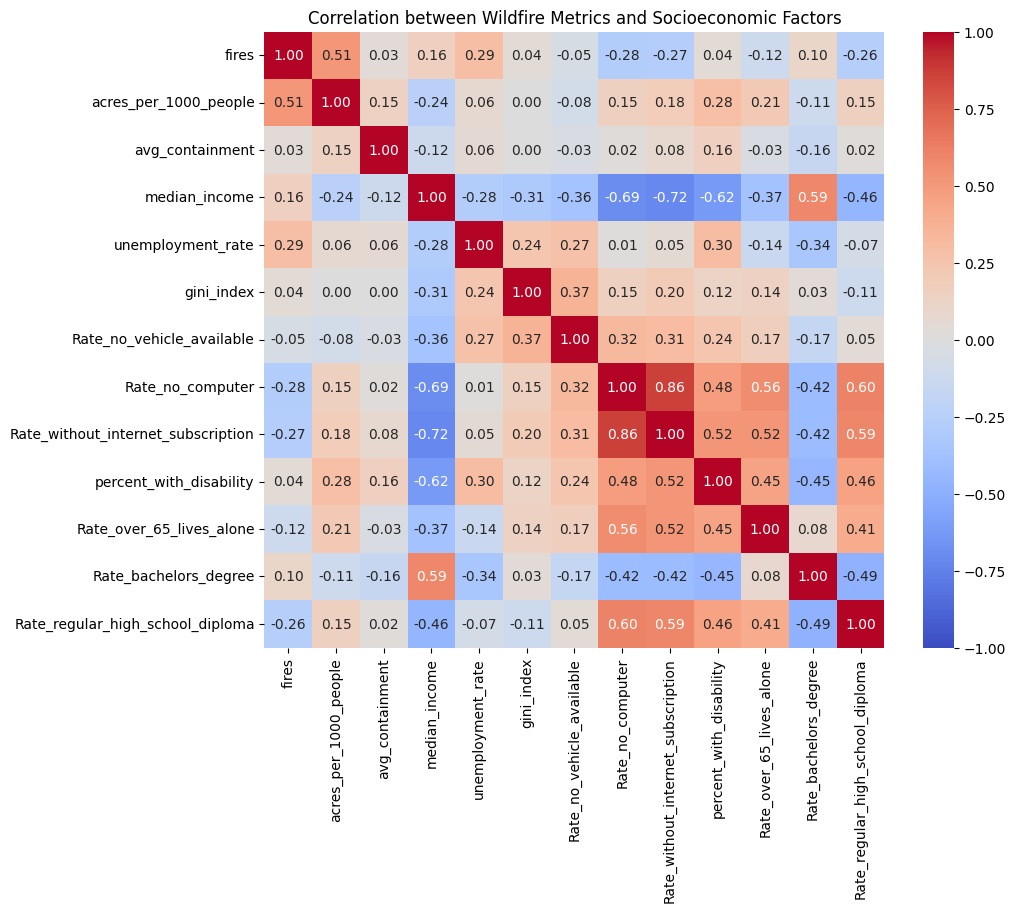

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = impact[cols].apply(pd.to_numeric, errors="coerce").corr(method="spearman")

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Wildfire Metrics and Socioeconomic Factors")
plt.show()

Interpretation

The correlation matrix highlights the relationships between indicators associated with fires and the socio-economic characteristics of the analyzed counties. A moderate positive correlation is observed between the number of fires and the burned area relative to population (acres_per_1000_people), suggesting that counties with more fires generally tend to also record a higher impact relative to the number of inhabitants. The average containment level has weak correlations with most variables, indicating that the level of fire control depends more on local operational factors than on general socio-economic characteristics.

In socio-economic terms, median income shows a moderate negative correlation with indicators such as: lack of a computer, lack of internet, lack of a vehicle, or disability, suggesting that lower-income areas are also those with reduced access to resources and infrastructure. At the same time, income correlates positively with the percentage of people with higher education and negatively with the unemployment rate and the percentage of those with only a high school diploma, outlining a consistent socio-educational profile. The Gini index is positively correlated with digital poverty and the lack of means of transport, indicating that income inequality is associated with multiple forms of social vulnerability.

A compact group of strong correlations appears between indicators of material exclusion: lack of a computer, lack of an internet connection, lack of a vehicle, and disability, which suggests an accumulation of disadvantages within the same communities. The relationships between socio-economic variables and fire variables are generally weak to moderate, showing that social factors can influence exposure and resilience, but do not fully explain fire dynamics.

Overall, the correlation matrix indicates the existence of well-defined socio-economic associations, while the links between fire characteristics and social variables are more diffuse and complex, requiring additional statistical models to capture the relationships between variables.

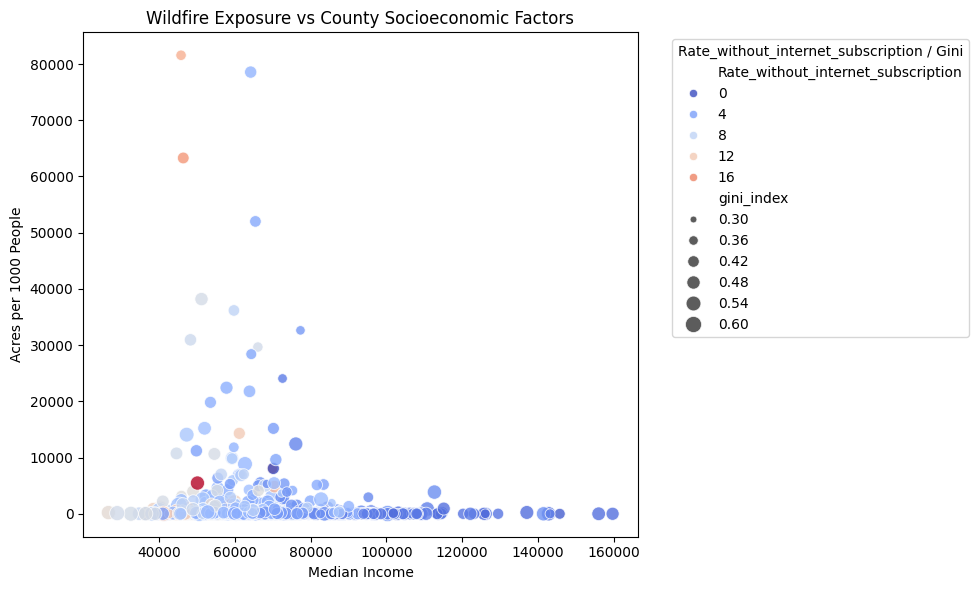

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=impact,
    x="median_income",
    y="acres_per_1000_people",
    size="gini_index",
    hue="Rate_without_internet_subscription",
    palette="coolwarm",
    sizes=(20, 150),
    alpha=0.8
)
plt.title("Wildfire Exposure vs County Socioeconomic Factors")
plt.xlabel("Median Income")
plt.ylabel("Acres per 1000 People")
plt.legend(title="Rate_without_internet_subscription / Gini", bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


Interpretation

"The chart illustrates the relationship between median household income and fire exposure, measured by the burned area per 1,000 inhabitants. The points represent counties, and for each, two additional socio-economic indicators are integrated: the rate of households without an internet subscription (represented by color) and the Gini index of income inequality (represented by circle size). The distribution of points shows that there is no clear linear relationship between median income and burned area per inhabitant, suggesting that fires affect counties across a wide range of income levels."

However, it is observed that extremely high values of burned area per inhabitant are primarily found in middle- or lower-income counties, while very high-income counties tend to record lower exposure values. This may indicate a more pronounced vulnerability of communities with limited economic resources or a lower capacity for prevention and intervention.

Analyzing the color-coded information, counties with higher percentages of the population without an internet subscription (warmer shades) appear more frequently among those with high fire exposure. This may suggest an association between digital poverty and vulnerability to environmental risks, possibly due to reduced access to information, alerts, and communication means in emergency situations. At the same time, the size of the circles shows that higher levels of income inequality (high Gini index) are present in some of the counties with high exposure, suggesting that fires may disproportionately affect communities where income distribution is already unbalanced.

Overall, the chart indicates that fire exposure is not determined exclusively by natural factors but intersects with socio-economic dimensions such as income, internet access, and economic inequality. This underscores the need for risk management policies that integrate both the ecological and social dimensions of the affected communities.

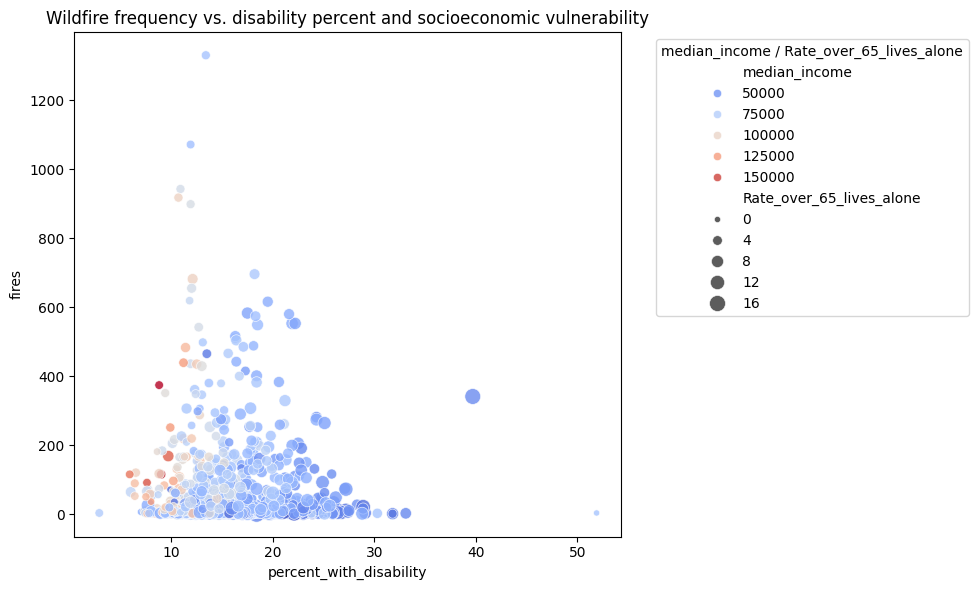

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=impact,
    x="percent_with_disability",
    y="fires",  # number of fires
    size="Rate_over_65_lives_alone",
    hue="median_income",
    palette="coolwarm",
    sizes=(20, 150),
    alpha=0.8
)
plt.title("Wildfire frequency vs. disability percent and socioeconomic vulnerability")
plt.xlabel("percent_with_disability")
plt.ylabel("fires")
plt.legend(title="median_income / Rate_over_65_lives_alone", bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


Interpretation

The chart illustrates the relationship between wildfire frequency (vertical axis – fires) and the percentage of people with disabilities in a county (horizontal axis – percent_with_disability). Each point represents a US county. It is observed that most counties are concentrated within the range of approximately 10%–25% of people with disabilities and record a relatively low number of fires, situated at the bottom of the chart. However, there are also counties with extremely high numbers of fires that stand out and can be considered outliers.

An important element is the shape of the scatter plot, which is not 'flattened' at the base of the chart but has an approximately triangular structure. As the percentage of people with disabilities increases, the dispersion of the values for the number of fires also increases: although many counties with high disability levels have few fires, there are also cases where high percentages of people with disabilities are associated with a very large number of fires. This shows that a significant portion of the population with disabilities is effectively exposed to areas with a high frequency of fires, not just low-risk areas.

No simple linear relationship is observed between the percentage of people with disabilities and fire frequency. Counties with small, medium, or large proportions of people with disabilities can record both few and very many fires. Therefore, the presence of people with disabilities does not directly explain the number of fires, but it has major relevance from the perspective of social vulnerability when they occur.

The color of the points reflects the median household income. Darker shades indicate lower incomes, while lighter shades indicate higher incomes. It is observed that numerous lower-income counties are found in areas with a higher frequency of fires, which may suggest limitations in prevention and control capacity. However, high-income counties with a large number of fires are also present, indicating that geographical and climatic factors play a significant role.

The size of the points represents the percentage of people over 65 living alone. Larger bubbles correspond to higher shares of this population. It is noted that some counties with high fire frequency also have significant proportions of elderly individuals living alone, indicating an additional social vulnerability regarding evacuation and disaster response.

Overall, the chart suggests that fire frequency does not depend exclusively on a single socio-demographic variable, but it highlights the overlap between fire intensity and the presence of vulnerable social groups, such as people with disabilities and the elderly living alone.

In [ ]:
import folium
from folium import Choropleth, GeoJsonTooltip
from IPython.display import display  # for Jupyter

# 1. Data preparation
# We assume 'counties' is a GeoDataFrame with geometries
# and 'impact' is a DataFrame with indicators (including log_acres_per_1000_people)

# Standardize county_fips to 5-character strings
counties["county_fips"] = counties["county_fips"].astype(str).str.zfill(5)
impact["county_fips"] = impact["county_fips"].astype(str).str.zfill(5)

# Create GEOID if missing (optional, only if needed elsewhere)
if "GEOID" not in counties.columns:
    counties["GEOID"] = counties["county_fips"]

# (OPTIONAL, but very important for performance)
# Simplify geometries to reduce HTML file size
# Try different tolerance values (0.001, 0.005, 0.01 etc.)
counties = counties.to_crs(epsg=4326)  # ensure WGS84 (lat/lon)
counties["geometry"] = counties["geometry"].simplify(
    tolerance=0.01,
    preserve_topology=True
)

# Merge counties with impact into a single GeoDataFrame
gdf = counties.merge(impact, on="county_fips", how="left")

# Keep only the columns needed for the map and tooltip
tooltip_fields = [
    "median_income",
    "Rate_over_65_lives_alone",
    "Rate_without_internet_subscription",
    "percent_with_disability",
    "total_population"
]

cols_needed = ["county_fips", "geometry", "log_acres_per_1000_people"] + tooltip_fields
gdf = gdf[cols_needed]

# 🔹 Round rate/percentage fields to one decimal (for display on the map)
rate_fields = [
    "Rate_over_65_lives_alone",
    "Rate_without_internet_subscription",
    "percent_with_disability"
]

for col in rate_fields:
    gdf[col] = gdf[col].round(1)

# 2. Create base map (prefer_canvas improves performance for many polygons)
m = folium.Map(
    location=[37.5, -119],
    zoom_start=5,
    tiles="cartodbpositron",
    prefer_canvas=True
)

# 3. Choropleth for wildfire exposure (log acres per 1000 people)
choro = Choropleth(
    geo_data=gdf,   # geometries + data in the same GeoDataFrame
    data=gdf,
    columns=["county_fips", "log_acres_per_1000_people"],
    key_on="feature.properties.county_fips",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Log Acres Burned per 1000 People"
).add_to(m)

# 4. Tooltip on hover with socioeconomic variables
#    Attach it directly to the GeoJSON layer of the choropleth to avoid duplicating geometries
GeoJsonTooltip(
    fields=tooltip_fields,
    aliases=[
        "median_income",
        "Rate_over_65_lives_alone",
        "Rate_without_internet_subscription",
        "percent_with_disability",
        "Total Population"
    ],
    # localize=True may slow down rendering; leave False if not needed
    localize=False
).add_to(choro.geojson)

# Display the map (for Jupyter)
display(m)


Visualizing US counties based on burned area per 1,000 inhabitants (indicated by color), alongside median income, the rate of people over 65, the rate of those without an internet subscription, the percentage of people with disabilities, and total population (indicated by labels)

STEP III: APPLYING MACHINE LEARNING MODELS

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
# List of features (fire + socioeconomic)
features = [
    "log_fires",
    "avg_containment",
    "log_median_income",
    "unemployment_rate",
    "gini_index",
    "Rate_no_vehicle_available",
    "Rate_no_computer",
    "Rate_without_internet_subscription",
    "percent_with_disability",
    "Rate_over_65_lives_alone",
    "Rate_bachelors_degree",
    "Rate_regular_high_school_diploma",
]

target = "log_acres_per_1000_people"

# Define X and y from the impact DataFrame
X = impact[features]
y = impact[target]

# Drop rows with NaN values that might have been introduced during feature engineering or merging
X = X.dropna()
y = y[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=45
)

# We work directly with X_train and X_test
X_train_scaled = X_train
X_test_scaled = X_test


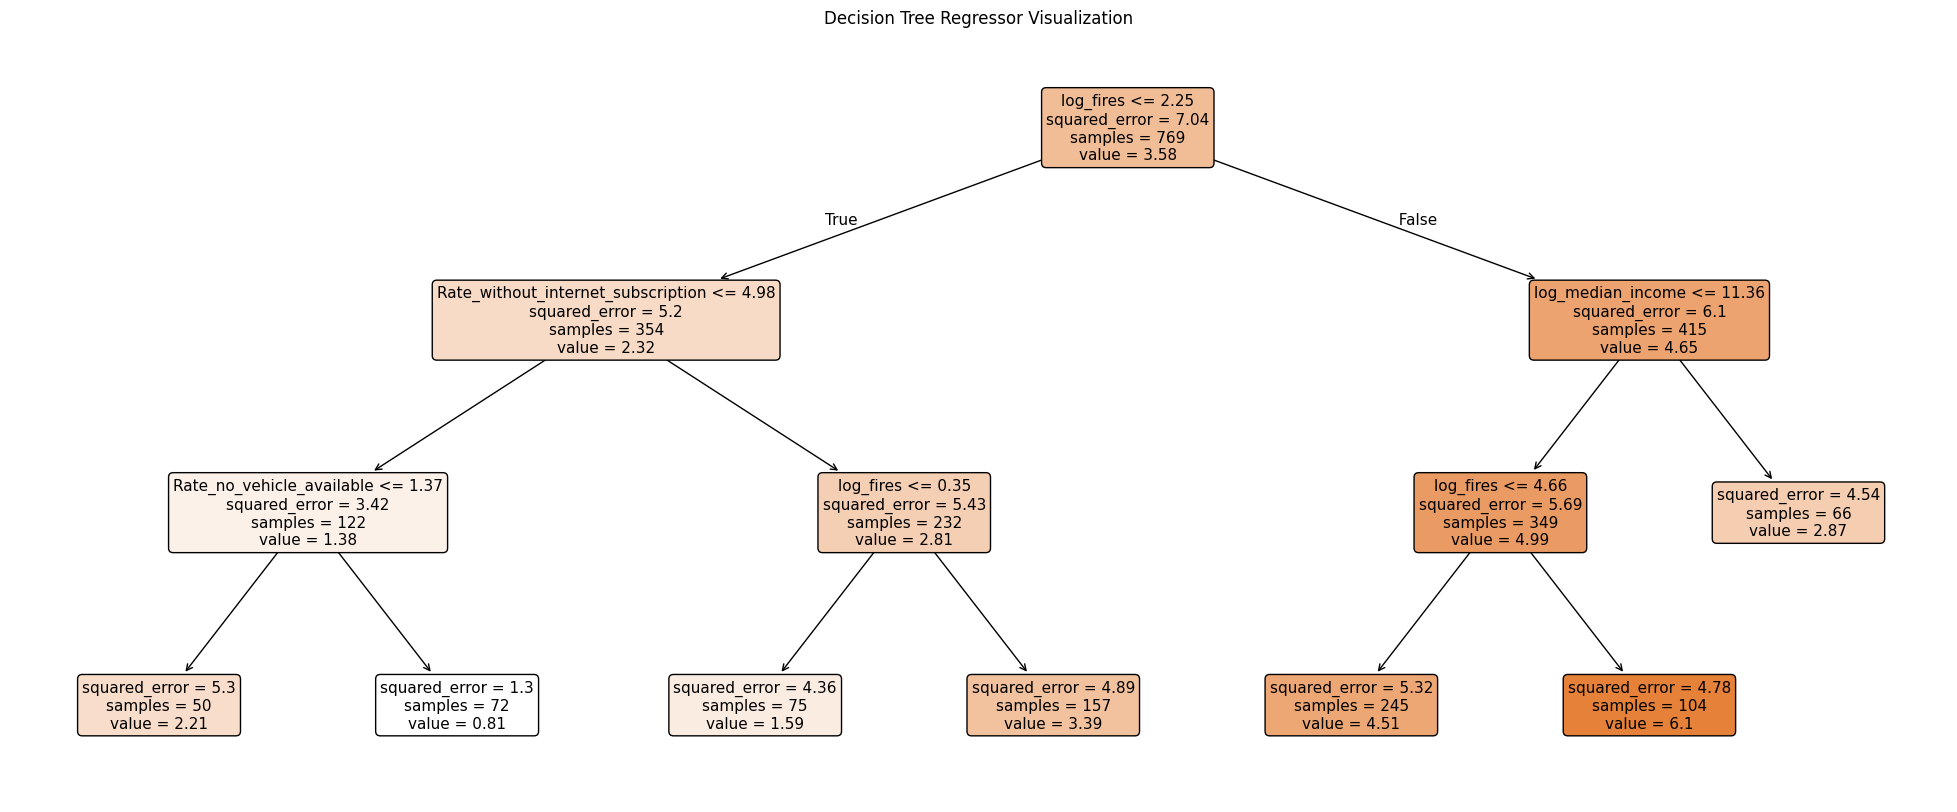

Decision Tree R² train: 0.34294131450376775
Decision Tree R² test : 0.3278199582262472
Decision Tree MAE test: 1.7344530881988915


In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Initialize and train the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=50,
    min_samples_split=100,
    random_state=42
)
dt_regressor.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(25,10))
plot_tree(dt_regressor, filled=True, feature_names=X_train.columns,
    rounded=True,
    precision=2,
    fontsize=11)
plt.title("Decision Tree Regressor Visualization")
plt.show()

from sklearn.metrics import r2_score, mean_absolute_error

y_pred_dt = dt_regressor.predict(X_test)
y_train_pred_dt = dt_regressor.predict(X_train)

print("Decision Tree R² train:", r2_score(y_train, y_train_pred_dt))
print("Decision Tree R² test :", r2_score(y_test, y_pred_dt))
print("Decision Tree MAE test:", mean_absolute_error(y_test, y_pred_dt))

Interpretation

The regression tree model uses the burned area relative to population (log acres per 1,000 inhabitants) as the target variable. The first segmentation criterion selected by the model is the number of fires (log_fires), which demonstrates that fire frequency is the primary determinant of exposure. Counties are initially split into two large groups: those with relatively low fire frequency and those with high frequency; subsequent branches show how socio-economic variables differentiate the level of impact within these groups.

On the left branch, corresponding to counties with a smaller number of fires, the model introduces the percentage of households without an internet subscription (Rate_without_internet_subscription) as the second criterion. Within this group, exposure tends to be higher in counties where internet access is lower, suggesting an association between social vulnerability and fire impact, including through mechanisms such as limited access to information, alerts, or prevention resources. Later in this branch, the percentage of households without a personal vehicle (Rate_no_vehicle_available) also plays an important role, indicating that low mobility and evacuation difficulties can contribute to an increased impact relative to population, even in areas with relatively low fire frequency.

On the right branch, corresponding to counties with a higher number of fires, the model introduces median household income (log_median_income) as a splitting variable. The results show that in these high-frequency fire areas, lower-income counties tend to exhibit higher values for burned area per inhabitant, while higher-income counties have, on average, lower values for this indicator. This result suggests that economic resources may be associated with a better capacity for prevention, home protection, or post-fire recovery, reducing the impact relative to population even when the hazard (number of fires) is high.

Regarding predictive performance, the model achieves an R² of approximately 0.34 on the training set and 0.33 on the testing set, while the Mean Absolute Error (MAE) on the test set is about 1.73 units on a logarithmic scale. The similar R² values on both train and test sets indicate that the model is not overfitted; however, the explanatory power is moderate: the tree captures an important, but not a majority, portion of the variation in burned area per inhabitant.

Overall, the model shows that the impact of wildfires is primarily determined by the hazard itself (number of fires) but is differentiated within county groups by variables related to access, infrastructure, and social vulnerability (lack of internet, lack of a vehicle) and economic status (median income). The moderate but stable performance of the model suggests that other factors—geographical, climatic, or related to land use—also play an important role, confirming that the tree should be viewed primarily as a tool for interpreting and understanding patterns rather than as a high-accuracy prediction model.

LGBM Model


In [ ]:
# LightGBM regularized to reduce overfitting
lgbm = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=15,
    max_depth=5,
    min_data_in_leaf=60,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=67
)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(50)]
)

# predictions using best iteration
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
y_train_pred = lgbm.predict(X_train, num_iteration=lgbm.best_iteration_)

print("LightGBM Performance")
print("R² train:", round(r2_score(y_train, y_train_pred), 3))
print("R² test :", round(r2_score(y_test, y_pred), 3))
print("MAE test:", round(mean_absolute_error(y_test, y_pred), 3))


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 769, number of used features: 12
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Start training from score 3.576350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

Interpretation

The regularized LightGBM model recorded a superior performance compared to the regression tree. The R² on the training set is approximately 0.72, and the R² on the test set is 0.55, indicating good predictive capacity, with a moderate difference between the two values and no strong evidence of overfitting. The Mean Absolute Error (MAE) on the test set is approximately 1.39 on a logarithmic scale, which corresponds to an average error of about fourfold in terms of burned area per 1,000 inhabitants. The results suggest that the boosting-type model succeeds in capturing non-linear relationships and interactions between socio-economic variables and fire indicators, outperforming the simple decision tree.

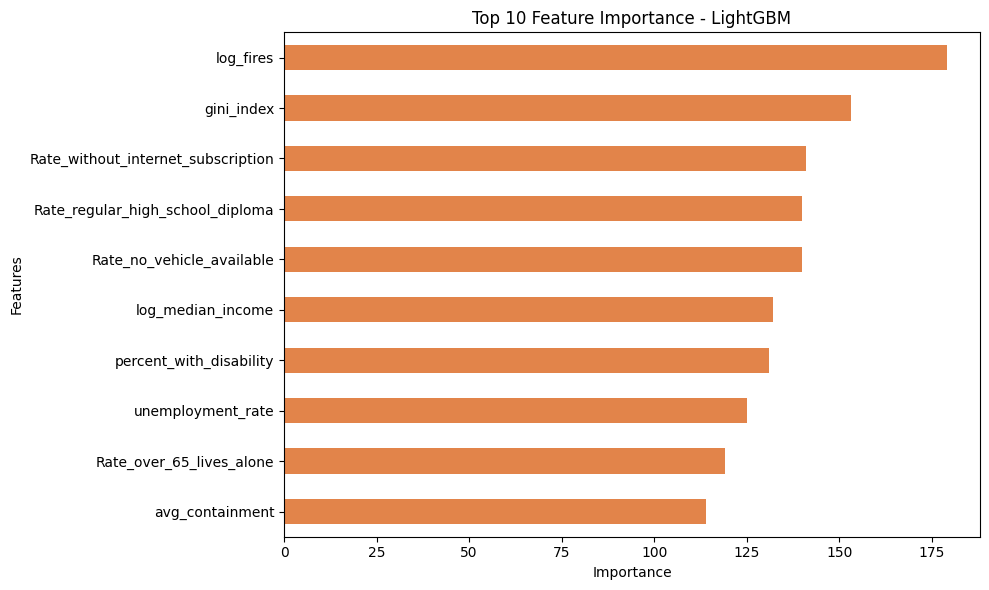

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

importances = lgbm.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=True)

plt.figure(figsize=(10,6))
feat_imp.tail(10).plot(kind="barh", color="#E2844A")
plt.title("Top 10 Feature Importance - LightGBM")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Interpretation

The feature importance analysis within the LightGBM model indicates that the most significant predictor of burned area relative to population is the number of fires (log_fires), confirming the dominant role of the hazard itself in determining impact. Alongside this, the Gini index—which measures income inequality—plays a substantial role, suggesting that fire impact is higher in communities characterized by pronounced economic disparities.

Among the social vulnerability variables, the lack of an internet subscription and the lack of a personal vehicle hold high importance in the model. This indicates possible links between reduced access to information, limited population mobility, and the intensity of fire effects. Educational attainment (the high school graduation rate) and median household income also contribute significantly to the predictions, reflecting complex relationships between socio-economic status and fire impact.

Other variables, such as the percentage of people with disabilities, the unemployment rate, and the share of people over 65 living alone, have a moderate but non-negligible importance, suggesting that demographic dimensions and individual vulnerability play a complementary role in explaining the impact. In contrast, the average containment degree (avg_containment) has lower importance in the final model, possibly because it is correlated with the number of fires or other operational intervention variables.

Overall, the results show that the impact of wildfires is not determined exclusively by the characteristics of the hazard, but is the result of the interaction between environmental factors and socio-economic factors related to inequality, access, education, and social vulnerability.

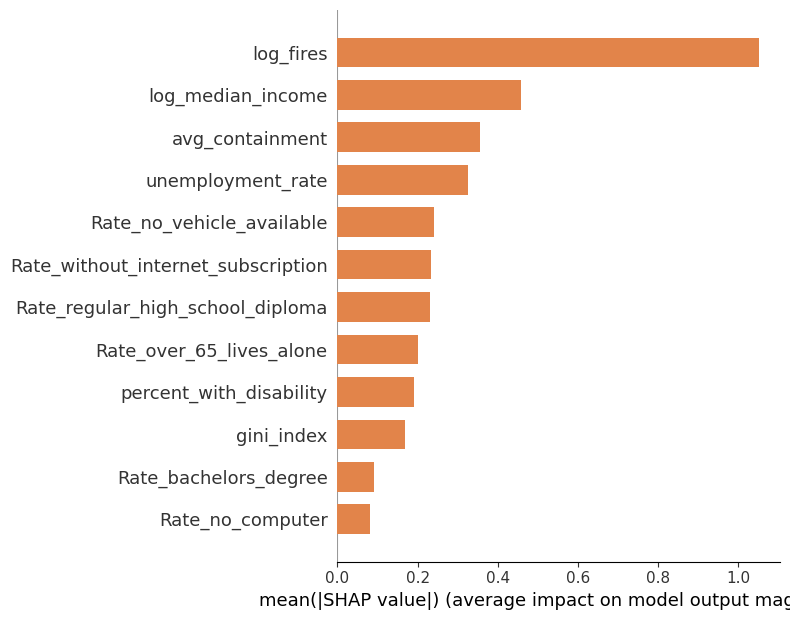

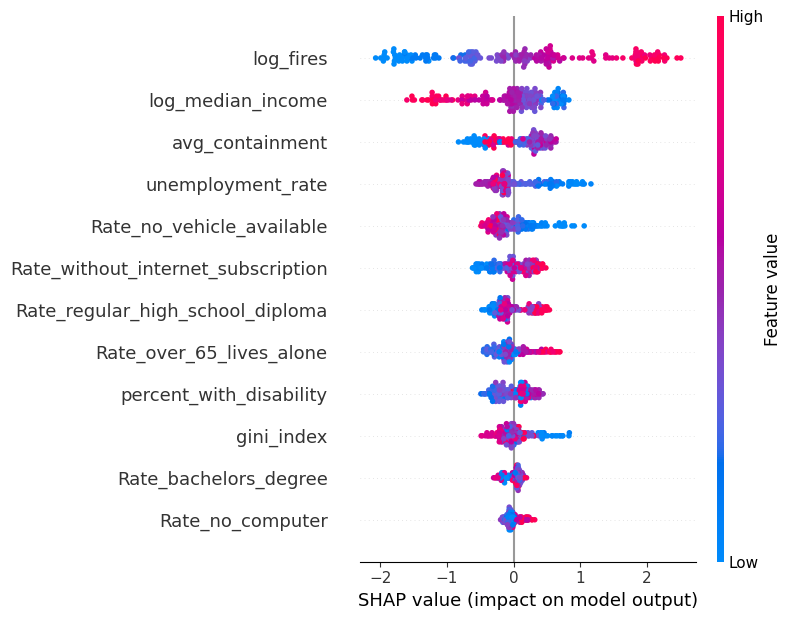

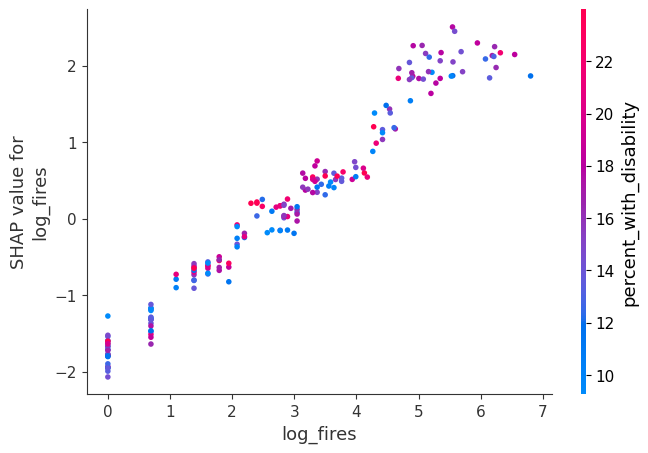

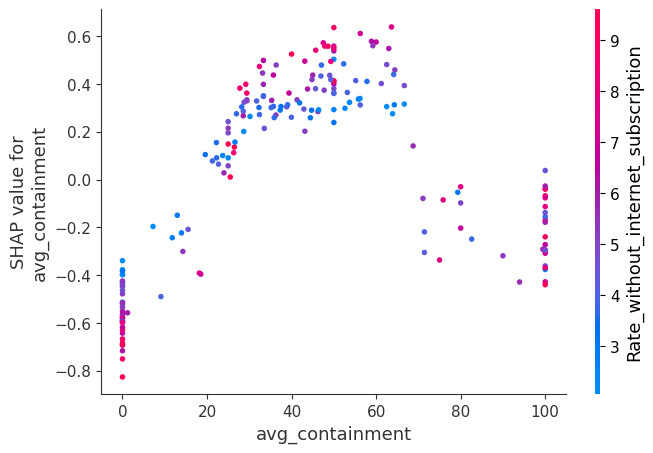

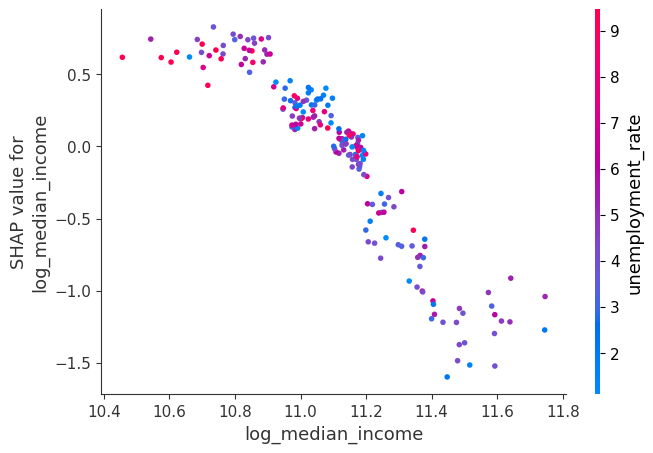

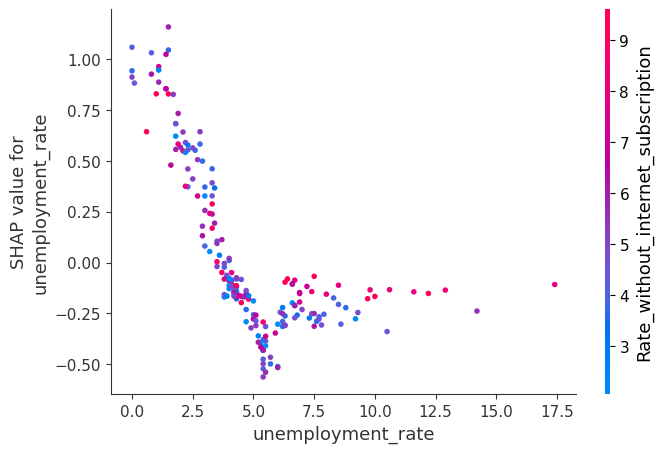

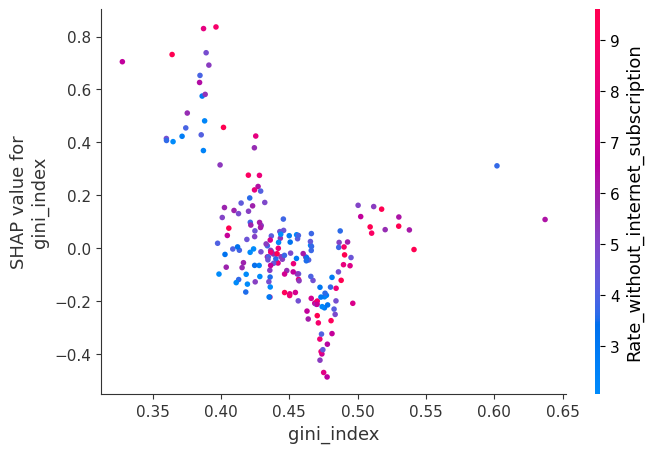

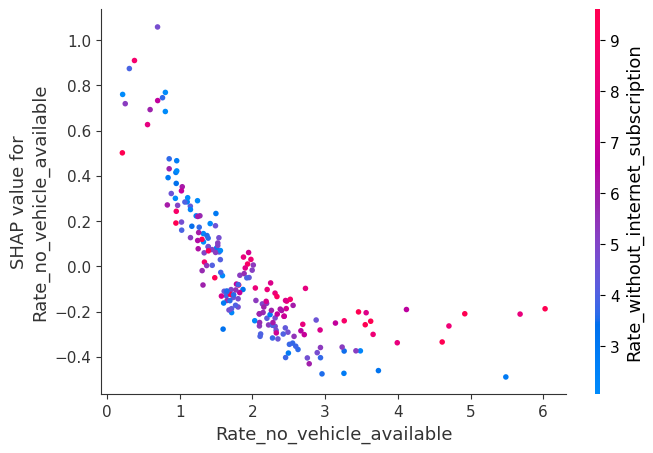

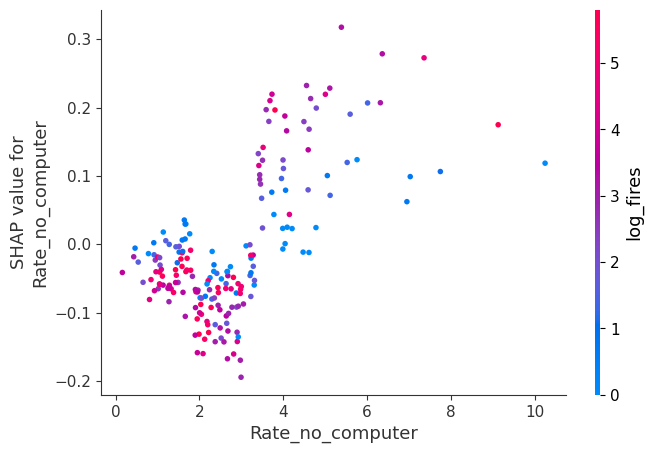

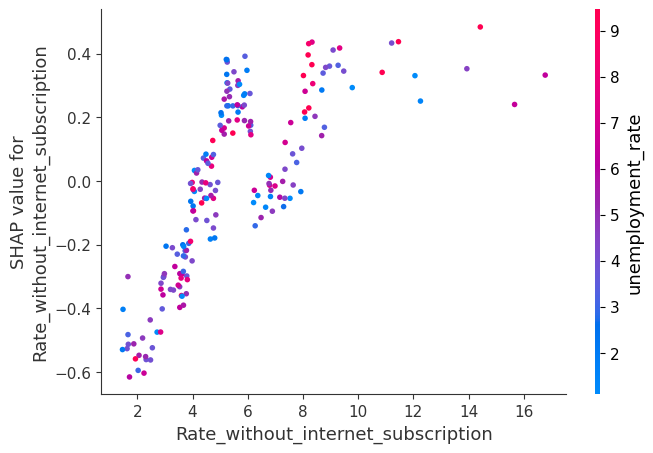

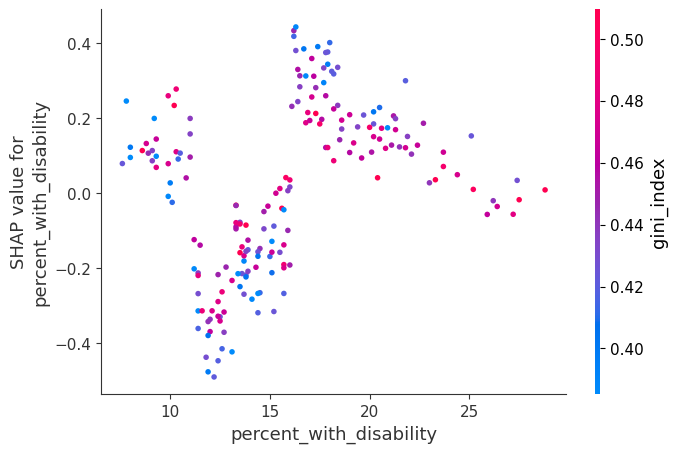

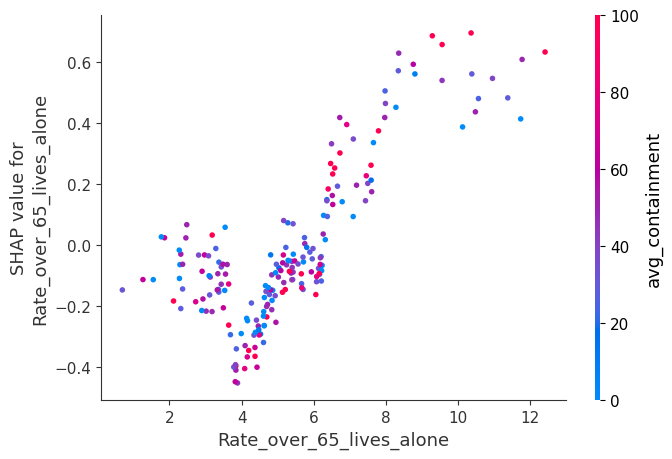

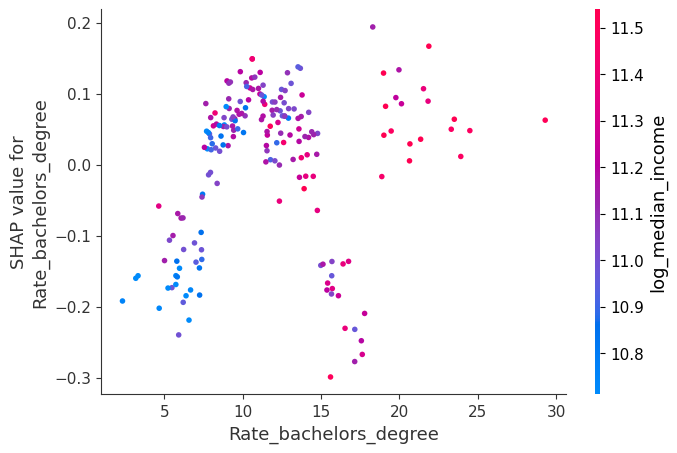

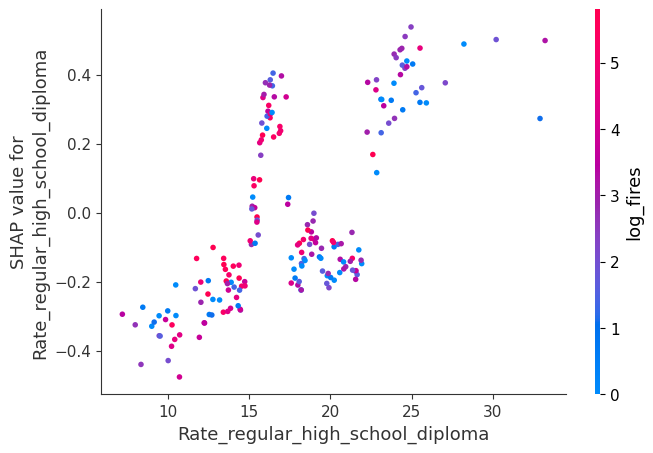

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize SHAP (for interactive plots in notebook environments)
shap.initjs()

# 2. Build a SHAP explainer for the trained LightGBM model
explainer = shap.TreeExplainer(lgbm)

# 3. Select the dataset for SHAP computation
# Option A: sample 300 observations from X_test
# X_test_sample = X_test.sample(n=300, random_state=42)

# Option B: use the full X_test dataset
X_test_sample = X_test

# 4. Compute SHAP values for the selected dataset
shap_values = explainer.shap_values(X_test_sample)

# 5. SHAP summary plot - bar chart (global feature importance)
shap.summary_plot(
    shap_values,
    X_test_sample,
    plot_type="bar",
    color="#E2844A"
)

# 6. SHAP summary plot - scatter plot
# Shows how each feature value influences the model prediction
shap.summary_plot(
    shap_values,
    X_test_sample,
    color="#E2774A"
)

# 7. SHAP dependence plots
# Shows how each individual feature affects the prediction
cols_for_shap = [
    "log_fires",
    "avg_containment",
    "log_median_income",
    "unemployment_rate",
    "gini_index",
    "Rate_no_vehicle_available",
    "Rate_no_computer",
    "Rate_without_internet_subscription",
    "percent_with_disability",
    "Rate_over_65_lives_alone",
    "Rate_bachelors_degree",
    "Rate_regular_high_school_diploma",
]

for col in cols_for_shap:
    shap.dependence_plot(
        col,
        shap_values,
        X_test_sample,
        display_features=X_test_sample
    )


Interpretation 1

The SHAP plot highlights the mean absolute importance of each variable on the LightGBM model's prediction. The results confirm that the number of fires (log_fires) is by far the most influential predictor of burned area relative to population, having a mean impact on the prediction much larger than any of the other variables. This shows that the hazard itself—fire frequency—remains the primary determinant of the analyzed outcome.

The second most important variable is median household income (log_median_income), suggesting that the economic status of communities plays a significant role in the model. Operational variables related to fire management (avg_containment), as well as socio-economic variables associated with vulnerability—such as the unemployment rate, lack of a personal vehicle, and lack of an internet subscription—also make an important contribution to modifying the predictions.

Variables such as the share of people with disabilities, the proportion of people over 65 living alone, educational attainment, or income inequality (Gini index) have a moderate but non-negligible importance. This indicates that while demographic and social vulnerability dimensions are not the dominant factors, they still influence the estimated impact of the fires.

Overall, the SHAP results show that the model captures a combination of hazard characteristics (number of fires), response capacity (containment), and the socio-economic conditions of the communities, suggesting that the impact of wildfires is the result of the interaction between environmental and social factors.

Interpretation 2

The SHAP 'beeswarm' plot simultaneously indicates the global importance of the variables and the direction of their effects on the target variable (burned area per 1,000 inhabitants, on a logarithmic scale). The results show that the number of fires (log_fires) is the primary determinant of impact: high values of this variable (red dots) are systematically associated with positive SHAP values, meaning they significantly increase the estimated level of burned area per inhabitant. Conversely, low values of log_fires (blue dots) shift the prediction downward, reducing the expected impact.

The median household income (log_median_income) presents an interesting pattern: low income values (blue) tend to be associated with positive SHAP values, increasing the estimated impact, while high incomes (red) are generally associated with negative effects on the prediction. This result suggests that, after controlling for fire frequency, lower-income counties tend to be more exposed, which may be linked to reduced prevention capacity, lower housing quality, or institutional limitations.

The avg_containment variable shows that higher values of the average 'containment' degree are associated with negative SHAP values, indicating a protective impact: more effective fire management reduces the burned area relative to population. High unemployment rates are associated with positive SHAP effects, suggesting that economic disadvantage correlates with increased fire impact.

For indicators of access and social vulnerability (lack of a vehicle, lack of an internet subscription, elderly living alone, people with disabilities), asymmetrical distributions are observed: high values of these variables tend to push the prediction upward. This supports the hypothesis that mobility limitations, reduced access to information, and the presence of vulnerable groups contribute to increasing the social impact of fires, even if they do not directly cause the fires themselves.

Overall, the SHAP plot confirms that fire impact is explained primarily by the intensity of the hazard (number of fires), but also by the socio-economic context: low income, high unemployment, and precarious social infrastructure increase the probability of a higher impact per inhabitant. Thus, wildfires represent not only a natural phenomenon but also a social one, the consequences of which are amplified in vulnerable communities.

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Random Forest
rf = RandomForestRegressor(
    n_estimators=600,      # number of trees in the forest
    max_depth=10,          # maximum depth of each tree
    min_samples_leaf=10,   # minimum number of samples required in a leaf node
    min_samples_split=10,  # minimum number of samples required to split an internal node
    max_features="sqrt",   # number of features considered when looking for the best split (square root of total features)
    random_state=600,      # random seed for reproducibility
    n_jobs=-1              # use all available CPU cores for parallel processing
)


# Training
rf.fit(X_train, y_train)

# Predictions for train and test
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Performance of model
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Random Forest performance")
print("R^2 train:", r2_train)
print("R^2 test :", r2_test)
print("RMSE test:", rmse_test)



Random Forest performance
R^2 train: 0.5908711770229516
R^2 test : 0.491523877824808
RMSE test: 1.9216545723860572


Interpretation

Random Forest clearly improves performance compared to the decision tree and approaches the performance of LightGBM, while maintaining a balance between accuracy and a low risk of overfitting. Compared to the simple regression tree, which explains approximately one-third of the variation in burned area per 1,000 inhabitants (R² ≈ 0.33), Random Forest succeeds in capturing the variation much better (R² ≈ 0.49 on the test set). The difference between the individual tree and complex models such as Random Forest and LightGBM confirms that the relationships between fire impact and socio-economic characteristics are not predominantly linear or 'single-factor' in nature; instead, they involve interactions and thresholds between variables. The results suggest that the association between hazard and social vulnerability is complex and arises from combinations of factors, rather than the isolated effect of a single variable.

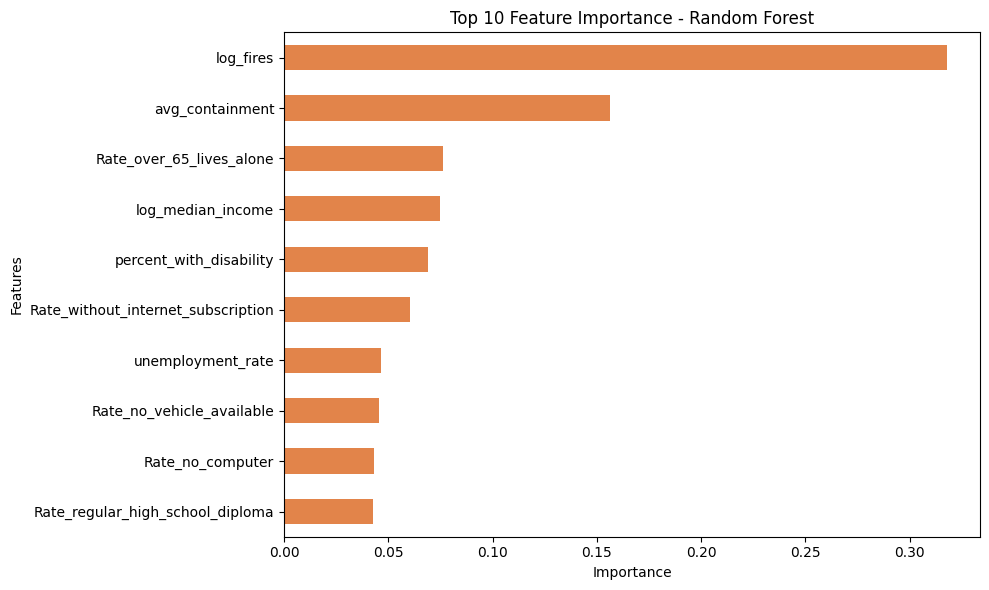

In [ ]:
import pandas as pd

rf_importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# print(rf_importances)

plt.figure(figsize=(10,6))
rf_importances.sort_values().tail(10).plot(kind="barh", color="#E2844A")
plt.title("Top 10 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



Interpretation

The Feature Importance chart presents the importance of the variables used in the Random Forest model to explain the burned area relative to the population. It is observed that the most important variable is the total number of fires (fires), which clearly dominates the contribution to the model's accuracy. This result indicates that the impact on the population is primarily determined by the frequency of fire events, confirming the central role of the hazard itself in explaining the burned area per inhabitant.

The second most important variable is the average fire containment level (avg_containment). Its importance suggests that it is not only the number of fires that matters but also how they are managed: lower containment levels are associated with fires that spread over larger areas. This reflects both the efficiency of intervention capacities and natural conditions that may limit flame control.

A third group consists of socio-demographic variables, such as the percentage of people with disabilities, the share of elderly living alone, median income, and the unemployment rate. Their importance is moderate but consistent, showing that they contribute to explaining the variation in impact without having the determining weight of hazard-related variables. These variables should be understood more as indicators of social vulnerability and differentiated access to resources, rather than direct causal factors for fire occurrence.

General Interpretation

The results obtained from the ensemble models (LightGBM and Random Forest), along with the feature importance analysis and SHAP plots, outline a coherent picture of the factors explaining the impact of wildfires. Both models achieve strong performance for such a complex natural phenomenon (R² ≈ 0.55 for LightGBM and R² ≈ 0.49 for Random Forest), explaining a significant portion of the variation in burned area relative to population. The relatively small gap between training and testing performance suggests that the models generalize adequately and do not suffer from significant overfitting.

Consistently, the most important predictors identified by both models are the variables directly describing fire dynamics: the total number of fires and the average containment level. High fire frequency and low containment levels are associated with a much higher impact on the population, indicating that the natural hazard itself is the primary determinant of burned area per inhabitant. This result is consistent across the feature importance rankings of both Random Forest and LightGBM, as well as the SHAP values.

The models also highlight the role of socio-economic variables, though primarily as vulnerability factors rather than direct determinants of fire occurrence. Indicators such as median income, the percentage of people with disabilities, the share of elderly living alone, unemployment, and limited internet access hold moderate but consistent importance. They signal territorial profiles where the capacity for response, evacuation, adaptation, and access to information is lower, which can amplify the impact when fires occur. These variables should not be interpreted as causal factors of the fires, but rather as elements of the social context in which the hazard manifests.

Overall, the results suggest that the impact of wildfires is the result of the interaction between: the intensity of the hazard (number and extent of fires), the efficiency of control and intervention, and the social and infrastructural vulnerability of the communities. The models not only provide predictions of the burned area but also point toward practical directions for intervention: beyond managing fire outbreaks, reducing social vulnerability, increasing access to information, and strengthening response capacities can diminish the consequences of fires on the population.

## Team Contributions

| Name         | Contributions                                |
|--------------|----------------------------------------------|
| PIRVAN Vlad-George     | Proposed the research idea, collected external data, conducted descriptive statistics and interpretations.          |
| NICOLA Eduard-George         | Implemented the code, performed data preprocessing, developed and evaluated the models.        |
| LUPES Razvan-Stefan       | Provided support throughout the analysis and created the final PowerPoint presentation      |